# Predicting clicks of each product
The data provided gives us, for each product, the amount of money earned by click (clc), the number of clicks and the number of views (i.e. how many times the product was shown). Ideally we want to maximize the money earned, which is given by clc * number of clicks, but at the same time we want to minimize the number of views, in order to be as efficient as possible.

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spstats
from scipy.stats import weibull_min
from pylab import *
from scipy import *
%matplotlib inline

In [218]:
scoring = pd.read_csv('product_scoring.csv')


In [219]:
print scoring.shape
scoring['money'] = scoring.cpc*scoring.clicks # not used but included for illustration
scoring.head()

(10000, 5)


product_id          category_id       cpc  clicks  views     money
0  6.288768e+18  7234842626579207420  1.100000     0.0   26.0  0.000000
1  7.511866e+18  3751288961258999757  1.800000     0.0  156.0  0.000000
2  1.249888e+17  5924358085291389806  1.640000     2.0   44.0  3.279999
3  1.943562e+18  7234842626579207420  1.100000     0.0    NaN  0.000000
4  4.896302e+18  7234842626579207420  1.099999     0.0    NaN  0.000000

In [220]:
# product containing NaN views
scoring[np.isnan(scoring.views)].shape

(5561, 6)

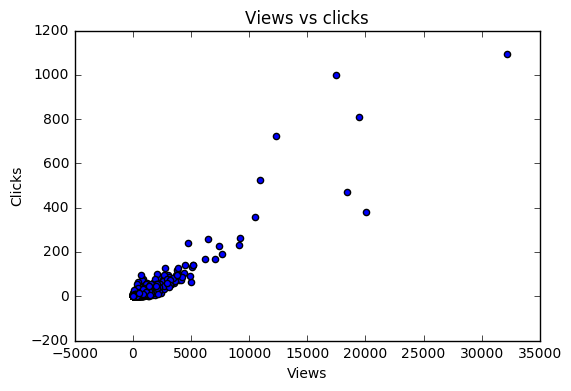

In [221]:
# Clicks function of views???
plt.scatter(scoring.views,scoring.clicks)
plt.title('Views vs clicks')
plt.xlabel('Views')
plt.ylabel('Clicks')
plt.show()

In [222]:
#cleaning up - only products having views different than NaN are considered
scoring_clean = scoring[~np.isnan(scoring.views)]

In [223]:
scoring_clean.shape

(4439, 6)

After reading this reference (http://www.evanmiller.org/how-not-to-sort-by-average-rating.html), we can list the following ideas:
- Average sorting does not work: that would mean that the product with highest number of clicks would be placed higher, instead of a product which, for instance, was displayed less times but got more clicks/view
- We need to account for products which are shown less times than others and therefore have different amounts of clicks than others
- The article suggests to use the Lower bound of Wilson score confidence interval (more on that later)

Also useful to check this reference on Reddit sorting algorithm (https://medium.com/hacking-and-gonzo/how-reddit-ranking-algorithms-work-ef111e33d0d9#.d50u3s91m)

Before using the suggested algorithm, we need to work on the dataset. For the algorithm, we need up and down votes, or positive and negative ratings.
In our case, we have simply product_id, number of clicks and number of views. One basic approach would be to categorize one view as "positive" if the user clicked in the product, and "negative" if the user did not click on it. 
We are for the moment neglecting the price per click, since that can probably be adjusted afterwards according to the final score. 

So the pre-processing involves creating a column in the data frame scoring_clean containing the number of positives and number of negatives, as described ealier. It is worth noting that I neglected category_id, which should be useful in case of product classification (not done here)

In [224]:
scoring_clean['negatives'] = scoring_clean.views - scoring_clean.clicks
scoring_clean['positives'] = scoring_clean.clicks

/Users/gabrielfior/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/gabrielfior/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [225]:
# take a look at the average rating
scoring_clean['average'] = scoring_clean.positives / scoring_clean.negatives

/Users/gabrielfior/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [226]:
def get_wilson(confidence,pos,n,scoring_clean,z):
    """
    pos = # of positive ratings
    n = total # of ratings
    confidence = confidence level (normally .95)
    """
    if z=='gaussian':
        z = 1.96 #hardcoded, 1.96 for alpha=0.95 gaussian case
    else:
        z = scoring_clean.quantile([confidence]).average.iloc[0]
    result_lower = ((pos + (z*z/2.)) / (n) - 
                   z * np.sqrt((pos * (n-pos)) / (n) + (z*z/4.)) / 
                          (n)) / (1. + (z*z) / (n)) 
    return result_lower

In [227]:
pos = scoring_clean.positives #number of positives
n = scoring_clean.views #total number of observations
confidence = 0.95

We may also try the Gaussian approach, but without much hope, since the data is clearly not gaussian distributed.
Nevertheless, this works as a first approach.

In [228]:
scoring_clean['wilson_gauss'] = get_wilson(confidence,pos,n,scoring_clean,z='gaussian')

/Users/gabrielfior/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Now we can use as our official wilson calculation the confidence level $95\%$. I got the $Z_{\alpha}$ by calculating the percentile of the dataset. This is of course a very basic approximation. A better one would be to actually fit the histogram. I did not have enough time, so I did not complete that, but I included some comments on my conclusions in the end

In [229]:
scoring_clean['wilson'] = get_wilson(confidence,pos,n,scoring_clean,z='infer')

/Users/gabrielfior/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [230]:
scoring_clean = scoring_clean.sort_values(by='wilson', axis=0, ascending=False)

In [231]:
scoring_clean.head()

product_id          category_id       cpc  clicks  views      money  \
6798  8.326994e+18  7234842626579207420  1.096039     8.0   20.0   8.768308   
4374  1.873431e+18  1923544693465519030  1.657496     9.0   23.0  14.917466   
8347  7.971607e+18  3151234738806572779  1.835173    13.0   42.0  23.857244   
1817  3.556890e+17  1923544693465519030  1.658973     8.0   26.0  13.271788   
1044  7.600695e+18  8432810112255698627  2.099385     6.0   22.0  12.596307   

      negatives  positives   average  wilson_gauss    wilson  
6798       12.0        8.0  0.666667      0.218804  0.392416  
4374       14.0        9.0  0.642857      0.221574  0.384260  
8347       29.0       13.0  0.448276      0.190709  0.304591  
1817       18.0        8.0  0.444444      0.165011  0.301442  
1044       16.0        6.0  0.375000      0.131506  0.266183

It was given as hint in the exercise that the underlying distribution is not normal distributed. That is clear by looking at the image below.
We see that there are a lot of scores close to 0, while it decreases going away from the origin.

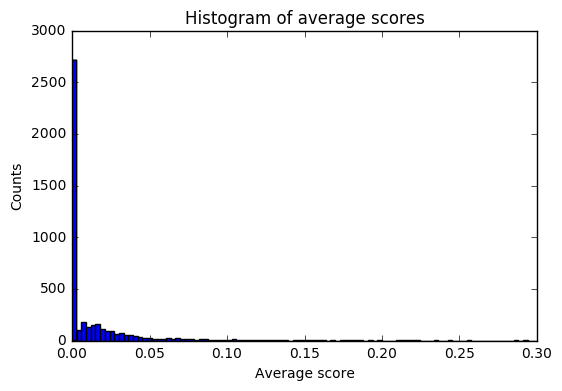

In [232]:
plt.hist(scoring_clean.average,bins=np.linspace(0,.3,100))
plt.title('Histogram of average scores')
plt.xlabel('Average score')
plt.ylabel('Counts')
plt.show()

In [238]:
# Get data from NaN, which were excluded before
prod_ids_nans = scoring[np.isnan(scoring.views)]['product_id']
prod_ids_nans = pd.DataFrame(prod_ids_nans)
prod_ids_nans['wilson'] = 0.0

In [234]:
prod_ids_nans.shape

(5561, 2)

In [235]:
export  = scoring_clean[['product_id','wilson']]

In [239]:
#include data containing views==NaN
export = export.append(prod_ids_nans,ignore_index=True)
#export = scoring_clean[['product_id','wilson']]

In [240]:
# export data
export.to_csv('score_per_product.csv',index=False,header=['product_id','score'])

As a summary, we could process the clicks and views data for several products and export a score for each product, which should be followed in order to display the products which should receive the most clicks per view. For that, the Wilson score confidence interval was chosen, to balance the fact that some products received far more views than others, therefore had less clicks.

# Remarks
- For this basic analysis, I cleaned up the data, since I neglected the products which had views = NaN. The reason was that those products also had 0 clicks, so that for this basic analysis it would be more interesting to proceed with the products actually clicked and seen.
- Wilson confidence interval: I compared both the standard case of a normal distributed variable, and the case where I put the confidence interval border as being equal to the 95% percentile. Since the first approach does not reflect how the clicks histogram is distributed, I used the latter as my score. It is worth noting that I got values from the data itself and not from a fit, so it's not the optimal approach. A next step would be to fit the histogram of scoring_clean.average and use that function to obtain the confidence intervals.
- As ideas for future improvement, it would be great to have more features on the clicks themselves, like where the visitor came from; how long he/she stayed on the website; date when the click took place.